In [1]:
from qpe import *
from numpy import log, cumsum, unique, argmin

import qutip as qp
from time import time

from numpy import sign, ceil
from numpy.random import randint

from scipy.stats import unitary_group, gaussian_kde

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D  
from matplotlib.colors import LinearSegmentedColormap
matplotlib.rcParams['font.family']='serif'
matplotlib.rcParams['axes.unicode_minus']=False
matplotlib.rcParams.update({'font.size': 22})
matplotlib.rc('text', usetex=True)

In [3]:
def train_shots(dms, labels, n_layers, n_shots, n_copies=1, n_meas=0, method="Cobyla", w_ls=1e0, w_var=1e-4,
                x0=None, options={}, save_data=False, file_name=None):

    n_inp = int(log2(len(dms[0])))
    n_tot = n_inp*n_copies
    d = 2**n_tot
        
    if n_meas == 0:
        n_meas = n_tot
                
    n_pars_est = 2**n_meas
    # n_pars_ans = (3*n_tot - 1)*n_layers + 2*n_tot # cry  
    n_pars_ans = (3*n_layers + 2)*n_tot # cry  
    
    d_diff = 2**(n_tot - n_meas)
    dms_cop = [reduce(kron, [dm]*n_copies) for dm in dms]

    fvals = []
    fval_cont = [0]

    # def fun(x):
    #     x_ans, x_est = x[:n_pars_ans], x[n_pars_ans:]
    #     U = hea_cry_rzrx(n_tot, n_layers, x_ans)
    #     expecs = []
    #     sq_expecs = []
    #     for dm in dms_cop:
    #         counts_trans = measure_z_counts(U@dm@U.conj().T, n_shots)/n_shots*x_est
    #         expec = np.sum(counts_trans)
    #         sq_expec = np.sum(counts_trans*x_est)
    #         expecs.append(expec)
    #         sq_expecs.append(sq_expec)
    #     disps = array(sq_expecs) - array(expecs)**2
    #     f_ls = np.sum((array(expecs) - array(labels_train))**2)
    #     f_var = np.sum(disps)
    #     f = w_ls*f_ls + w_var*f_var
    #     fval_cont[0] = f
    #     return f

    # def fun(x):
    #     """ x5 faster for 1000 4-qubit states with 10000 shots """
    #     x_ans, x_est = x[:n_pars_ans], x[n_pars_ans:]
    #     U = hea_cry_rzrx(n_tot, n_layers, x_ans)
    #     dms_cop_u = [U@dm@U.conj().T for dm in dms_cop]
    #     counts_list = []
    #     with Pool() as pool:
    #         counts_list = pool.map(partial(measure_z_counts, n_shots=n_shots), dms_cop_u)
    #     expecs = array(counts_list)*x_est/n_shots
    #     sq_expecs = expecs*x_est
    #     f_ls = np.sum((np.sum(expecs, axis=1) - array(labels_train))**2)
    #     f_var = np.sum(np.sum(sq_expecs, axis=1) - np.sum(expecs, axis=1)**2)
    #     f = w_ls*f_ls + w_var*f_var
    #     # print("\t\tFunction value: %.8f" %f, end="\r")
    #     fval_cont[0] = f
    #     return f

    def fun(x):
        """ Faster for N>=8 """
        x_ans, x_est = x[:n_pars_ans], x[n_pars_ans:]
        U = hea_cry_rzrx(n_tot, n_layers, x_ans)
        U_dag = U.conj().T
        dms_cop_u = [U@dm@U_dag for dm in dms_cop]
        counts_list = array([measure_z_counts(dm, n_shots) for dm in dms_cop_u])
        expecs = counts_list*x_est/n_shots
        sq_expecs = np.sum(expecs*x_est, axis=1)
        expecs = np.sum(expecs, axis=1)
        f_ls = np.sum((expecs - array(labels_train))**2)
        f_var = np.sum(sq_expecs - expecs**2)
        f = w_ls*f_ls + w_var*f_var
        fval_cont[0] = f
        return f
    
    if file_name is None:
        file_name = "pars-c=%d-m=%d=l=%d-s=%d-w_ls=%f-w_var=%f-n_train=%d" %(n_copies, n_meas, n_layers, n_shots, w_ls, w_var, len(labels))
    
    def callback(x):
        fvals.append(fval_cont[0])
        print("\t\tIteration: %d | Function value: %.8f" %(len(fvals), fval_cont[0]), end="\r")
        if save_data == True:
            np.save(file_name, x)
        return None
    
    if method in ["Nelder-Mead", "L-BFGS-B", "SLSQP", "TNC", "Powell", "COBYLA"]:
        bounds = [(0, 2*pi)]*n_pars_ans + [(-10, 10)]*n_pars_est
    else:
        bounds = None
    if x0 is None:
        x0_ans = normal(pi, 0.01*pi, n_pars_ans)
        x0_est = normal(0, 0.01, n_pars_est)
        x0 = concatenate([x0_ans, x0_est])
    
    optimization_result = minimize(fun=fun, x0=x0, bounds=bounds, method=method, callback=callback, options=options) # "maxiter": int(1e10)

    return fvals, optimization_result

In [4]:
def estimate_shots(dms, labels, n_layers, pars, n_shots, n_copies=1, n_meas=0, n_est=1):
        
    n_inp = int(log2(len(dms[0])))
    n_tot = n_inp*n_copies
    d = 2**n_tot

    if n_meas == 0:
        n_meas = n_tot
    
    pars_ans = pars[:-2**n_meas]
    pars_est = pars[-2**n_meas:]

    U = hea_cry_rzrx(n_tot, n_layers, pars_ans)
    dms_cop = [reduce(kron, [U@dm@U.conj().T]*n_copies) for dm in dms]
    
    preds = []
    errors = []
    for e in range(n_est):
        print("\t\tEstimation run: %d" %e, end="\r")
        preds_e = []
        errors_e = []
        for j in range(len(dms)):
            counts = measure_z_counts(dms_cop[j], n_shots)
            pred_j = np.sum(counts/n_shots*pars_est)
            error_j = (pred_j - labels[j])**2
            preds_e.append(pred_j)
            errors_e.append(error_j)
        preds.append(array(preds_e))
        errors.append(array(errors_e))
        
    return array(preds), array(errors)

In [5]:
def aux_info(channel_func, channel_pars, channel_args, dm_ini, pars, n_layers, n_copies=1, n_meas=0, dp=1e-5):
    """ For the optimized variables theta and x,
    calculates the expectations expecs, their derivatives excepcs_der,
    their variances disps, and quantum and classical Fisher informations. """

    n_inp = int(log2(len(dm_ini)))
    n_tot = n_inp*n_copies

    if n_meas == 0:
        n_meas = n_tot
    
    pars_ans = pars[:-2**n_meas]
    pars_est = pars[-2**n_meas:]
    
    ansatz = hea_cry_rzrx(n_tot, n_layers, pars_ans)
    projs = [reduce(kron, [diag(line), eye(2**(n_tot - n_meas))]) for line in eye(2**n_meas)]
    projs_u = [ansatz.conj().T@proj@ansatz for proj in projs]

    dms_n = []
    dms_n_p = []
    dms_n_m = []
    for p in channel_pars:
        dm_n = reduce(kron, [channel_func(dm_ini, p, *channel_args)]*n_copies)
        dm_n_p = reduce(kron, [channel_func(dm_ini, p+dp, *channel_args)]*n_copies)
        dm_n_m = reduce(kron, [channel_func(dm_ini, p-dp, *channel_args)]*n_copies)
        dms_n.append(dm_n)
        dms_n_p.append(dm_n_p)
        dms_n_m.append(dm_n_m)

    expecs = []
    expecs_der = []
    disps = []
    CFIs = []
    QFIs = []
    for j in range(len(channel_pars)): # take a density matrix from the training set
        probs = [trace(dms_n[j]@proj).real for proj in projs_u]
        probs_der = [trace((dms_n_p[j] - dms_n_m[j])@proj).real/(2*dp) for proj in projs_u]
        expec = sum([out_i*prob_i for out_i, prob_i in zip(pars_est, probs)])
        expec_der = sum([out*prob_der for out, prob_der in zip(pars_est, probs_der)])
        # expec_der = trace(trace((dms_n_p[j] - dms_n_m[j])@proj)
        disp = sum([out_i**2*prob_i for out_i, prob_i in zip(pars_est, probs)]) - expec**2
        CFI = sum([prob_der**2/prob if prob > 0 else 0 for prob_der, prob in zip(probs_der, probs)]) + 1e-10
        QFI = 2*(1 - sqrt(fidelity(dms_n_m[j], dms_n_p[j]))) / dp**2 + 1e-10 # via centered differences 
        expecs.append(expec)
        expecs_der.append(expec_der)
        disps.append(disp)
        CFIs.append(CFI)
        QFIs.append(QFI)
    
    return array(expecs), array(expecs_der), array(disps), array(CFIs), array(QFIs)

# Single copy

In [6]:
channel_func = generalized_amplitude_damping_channel; channel_args = [0, 0]; channel_name = "ad"
# channel_func = z_rot; channel_args = [0]; channel_name = "zrot"
# channel_func = depolarizing_channel; channel_args = []; channel_name = "depolarizing"

# sv_ini = array(rand_ket(2))
# dm_ini = outer(sv_ini, sv_ini.conj().T)
# dm_ini = array(qp.rand_dm_hs(2))
# dm_ini = eye(2)/2
dm_ini = (eye(2) + X)/2
# dm_ini = (eye(2) + Z)/2

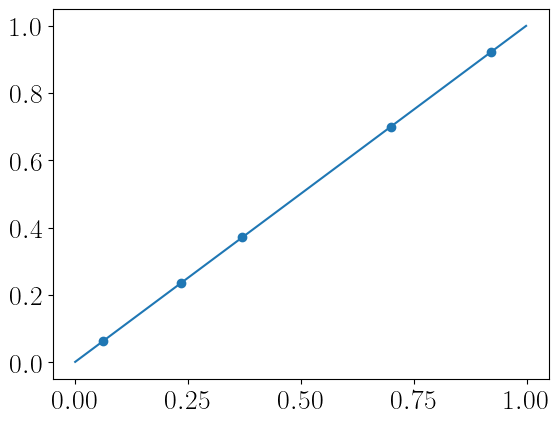

In [47]:
a = 1e-3
b = 1 - 1e-3
T = 5
V = 101

# labels_train = linspace(a, b, T)
labels_train = np.sort(uniform(a, b, T))
dms_train = [channel_func(dm_ini, p, *channel_args) for p in labels_train]

labels_test = linspace(a, b, V)
dms_test = [channel_func(dm_ini, p, *channel_args) for p in labels_test]

plt.scatter(labels_train, labels_train)
plt.plot(linspace(a, b), linspace(a, b))

## Many runs

In [76]:
method = "COBYQA"
n_copies = 1
n_inp = int(log2(len(dm_ini)))
n_meas = n_inp*n_copies
n_layers = 1
# n_shots_list = [100, 1000, 10000]#, 100000]
n_shots_list = [2**6, 2**10, 2**14]#, 100000]
n_runs = 30
w_ls = 1
w_var = 1e-4
options = {"maxiter": 5000}
dp = 1e-5

# x0_list = [[concatenate([uniform(0, 2*pi, (3*n_inp*n_copies - 1)*n_layers + 2*n_inp*n_copies), normal(0., 1, 2**n_meas)]) for r in range(n_runs)] for s in range(len(n_shots_list))]
x0_list = [[concatenate([uniform(0, 2*pi, (3*n_layers + 2)*n_inp*n_copies), normal(0., 1, 2**n_meas)]) for r in range(n_runs)] for s in range(len(n_shots_list))]

In [77]:
fvals_list = []
fval_fin_list = []
results_list = []
times_list = []
for s in range(len(n_shots_list)):
    print("n_shots:", n_shots_list[s])
    fvals_r_list = []
    fval_fin_r_list = []
    results_r_list = []
    times_r_list = []
    for r in range(n_runs):
        print("\tr:", r)
        time_start = time()
        fvals_r, result_r = train_shots(dms_train, labels_train, n_layers, n_shots_list[s], n_copies=n_copies, n_meas=n_meas, method=method, 
                                        w_ls=w_ls, w_var=w_var, x0=x0_list[s][r], options=options)
        time_finish = time() - time_start
        print()
        print("\t\tFinished in", time_finish)
        print("\t\t", result_r.message)
        fvals_r_list.append(fvals_r)
        fval_fin_r_list.append(result_r.fun)
        results_r_list.append(result_r)
        times_r_list.append(time_finish)
    fvals_list.append(fvals_r_list)
    fval_fin_list.append(fval_fin_r_list)
    results_list.append(results_r_list)
    times_list.append(times_r_list)

n_shots: 64
	r: 0
		Iteration: 141 | Function value: 0.03520260
		Finished in 0.2738945484161377
		 The lower bound for the trust-region radius has been reached
	r: 1
		Iteration: 137 | Function value: 0.04891784
		Finished in 0.24941635131835938
		 The lower bound for the trust-region radius has been reached
	r: 2
		Iteration: 121 | Function value: 0.09896668
		Finished in 0.22097444534301758
		 The lower bound for the trust-region radius has been reached
	r: 3
		Iteration: 129 | Function value: 0.13041572
		Finished in 0.2196340560913086
		 The lower bound for the trust-region radius has been reached
	r: 4
		Iteration: 122 | Function value: 0.18886259
		Finished in 0.21168041229248047
		 The lower bound for the trust-region radius has been reached
	r: 5
		Iteration: 146 | Function value: 0.16980335
		Finished in 0.2516512870788574
		 The lower bound for the trust-region radius has been reached
	r: 6
		Iteration: 135 | Function value: 0.32822478
		Finished in 0.2299642562866211
		 The

In [78]:
fvals_inf, result_inf = train(dms_train, labels_train, n_layers, n_copies=n_copies, n_meas=n_meas, method="BFGS", 
                              w_ls=w_ls, w_var=w_var, x0=None, options={})
pars_inf = result_inf.x

dp=1e-6

expecs_train_inf, expecs_der_train_inf, disps_train_inf, CFIs_train_inf, QFIs_train_inf = aux_info(channel_func, labels_train, 
                                                                                                   channel_args, dm_ini, pars_inf, n_layers,
                                                                                                   n_copies=n_copies, n_meas=n_meas, dp=dp)
expecs_test_inf, expecs_der_test_inf, disps_test_inf, CFIs_test_inf, QFIs_test_inf = aux_info(channel_func, labels_test, 
                                                                                              channel_args, dm_ini, pars_inf, n_layers,
                                                                                              n_copies=n_copies, n_meas=n_meas, dp=dp)

In [79]:
n_est = 1000
preds_train_list, expecs_train_list, expecs_der_train_list, disps_train_list, errors_train_list, CFIs_train_list, QFIs_train_list = [], [], [], [], [], [], []
preds_test_list, expecs_test_list, expecs_der_test_list, disps_test_list, errors_test_list, CFIs_test_list, QFIs_test_list = [], [], [], [], [], [], []
for s in range(len(n_shots_list)):
    print("n_shots:", n_shots_list[s])
    n_shots = n_shots_list[s]
    ind = argmin(fval_fin_list[s])
    pars = results_list[s][ind].x
    
    print("\tTraining data")
    preds_train, errors_train = estimate_shots(dms_train, labels_train, n_layers, pars, n_shots, n_est=n_est, n_copies=n_copies, n_meas=n_meas)
    expecs_train, expecs_der_train, disps_train, CFIs_train, QFIs_train = aux_info(channel_func, labels_train, channel_args, dm_ini, pars, n_layers, n_copies=n_copies, n_meas=n_meas, dp=dp)
    print()
    
    print("\tTesting data")
    preds_test, errors_test = estimate_shots(dms_test, labels_test, n_layers, pars, n_shots, n_est=n_est, n_copies=n_copies, n_meas=n_meas)
    expecs_test, expecs_der_test, disps_test, CFIs_test, QFIs_test = aux_info(channel_func, labels_test, channel_args, dm_ini, pars, n_layers, n_copies=n_copies, n_meas=n_meas, dp=dp)
    print()
    preds_train_list.append(preds_train)
    expecs_train_list.append(expecs_train)
    errors_train_list.append(errors_train)
    expecs_der_train_list.append(expecs_der_train)
    disps_train_list.append(disps_train)
    CFIs_train_list.append(CFIs_train)
    QFIs_train_list.append(QFIs_train)
    
    preds_test_list.append(preds_test)
    expecs_test_list.append(expecs_test)
    errors_test_list.append(errors_test)
    expecs_der_test_list.append(expecs_der_test)
    disps_test_list.append(disps_test)
    CFIs_test_list.append(CFIs_test)
    QFIs_test_list.append(QFIs_test)

n_shots: 64
	Training data
		Estimation run: 999
	Testing data
		Estimation run: 999
n_shots: 1024
	Training data
		Estimation run: 999
	Testing data
		Estimation run: 999
n_shots: 16384
	Training data
		Estimation run: 999
	Testing data
		Estimation run: 999


In [130]:
save_path = "/home/kardashin/Work/QPE/Results/Channels/"
file_info = channel_name + "-shots" + "-" + method

In [131]:
save_path + file_info + "-est.pdf"

'/home/kardashin/Work/QPE/Results/Channels/ad-shots-COBYQA-est.pdf'

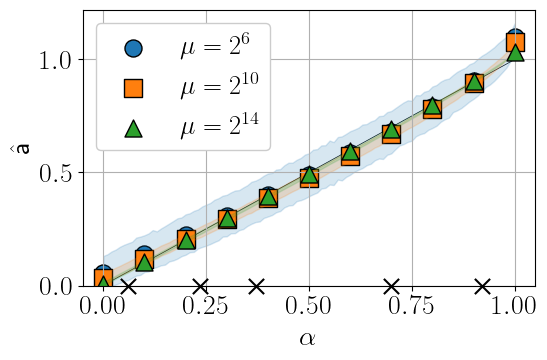

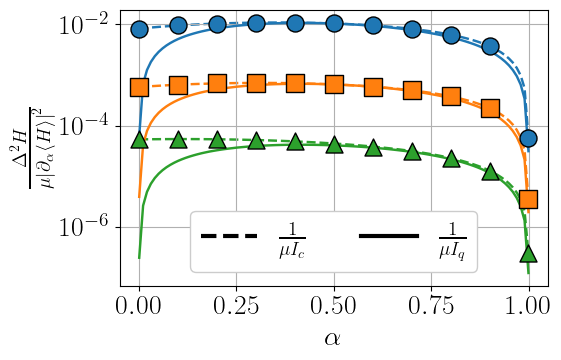

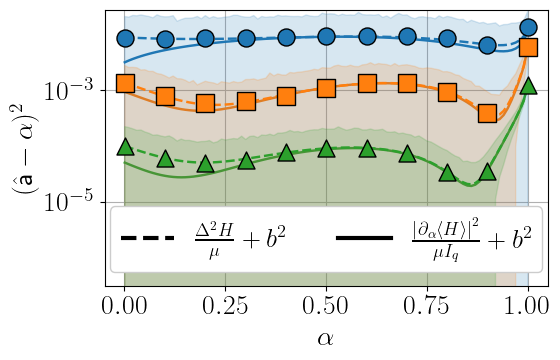

In [152]:
matplotlib.rcParams.update({'font.size': 20})

markers = ["o", "s", "^", "d"]#, "*"]
colors = ["C0", "C1", "C2", "C3"]#, "C4"]

me = 10

plt.figure(figsize=(6, 4))
for s in range(len(n_shots_list)):
    yest = np.mean(preds_test_list[s], axis=0)
    yerr = std(preds_test_list[s], axis=0)
    label = r"$\mu=2^{%d}$"%(int(np.log2(n_shots_list[s]))) # r"$\mu=%d$"%n_shots_list[s]
    plt.scatter(labels_test[::me], yest[::me], s=150, zorder=s, ec="black", linewidth=1, marker=markers[s], color=colors[s], label=label)
    plt.fill_between(labels_test, yest - yerr, yest + yerr, color=colors[s], alpha=0.175, linewidth=1)
    # plt.errorbar(labels_test, yest, yerr=yerr, capsize=2, zorder=s, marker=markers[s], label=r"$\mu=%d$"%n_shots_list[s])
# plt.scatter(labels_test, expecs_test_inf, s=120, zorder=s, ec="black", linewidth=0.5, marker=markers[-1], color=colors[-1], label=r"$\mu=\infty$")
plt.plot(labels_test, labels_test, color="black", linewidth=0.5, zorder=-1) 
plt.scatter(labels_train, [0]*T, color="black", s=120, marker="x", zorder=10, clip_on=False) # , label="Training data"
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\hat{\mathsf{a}}$")
plt.ylim(ymin=0)
# plt.xticks([0, 1/3, 2/3, 3/3, 4/3], [r"$0$", r"$1/3$", r"$2/3$", r"$1$", r"$4/3$"]) # for the depolarizing channel
# plt.yticks([0, 1/3, 2/3, 3/3, 4/3], [r"$0$", r"$1/3$", r"$2/3$", r"$1$", r"$4/3$"]) # for the depolarizing channel
plt.grid(zorder=0)
plt.legend(framealpha=1, fontsize=19, ncol=1)
plt.tight_layout()
plt.savefig(save_path + file_info + "-est.pdf", transparent=True, bbox_inches='tight')
plt.show()

plt.figure(figsize=(6, 4))
for s in range(len(n_shots_list)):
    yest = n_copies*disps_test_list[s]/expecs_der_test_list[s]**2/n_shots_list[s]
    plt.scatter(labels_test[::me], yest[::me], s=150, marker=markers[s], color=colors[s], ec="black", linewidth=1, zorder=3) # , label=r"$\mu=%d$"%n_shots_list[s]
    plt.plot(np.sort(labels_test), n_copies/QFIs_test_list[s]/n_shots_list[s], color=colors[s], linewidth=1.75, linestyle="solid", zorder=2) # , color="tab:blue", label=r"$\frac{1}{I_q}$"
    plt.plot(np.sort(labels_test), n_copies/CFIs_test_list[s]/n_shots_list[s], color=colors[s], linewidth=1.75, linestyle="dashed", zorder=1) # , color="tab:red"
# plt.scatter(labels_test, n_copies*disps_test_inf/expecs_der_test_inf**2, s=50, zorder=10, marker=markers[-1], color=colors[-1], ec="black", linewidth=0.5) # , label=r"$\mu=\infty$"
# plt.plot(np.sort(labels_test), n_copies/QFIs_test_inf, color=colors[-1], linewidth=1.5, linestyle="solid") # , color="tab:blue", label=r"$\frac{1}{I_q}$"
# plt.plot(np.sort(labels_test), n_copies/CFIs_test_inf, color=colors[-1], label=r"$\frac{1}{I_c}$", linewidth=1.5, linestyle="dashed") # , color="tab:red"
# plt.plot(np.sort(labels_test), [n_copies]*len(QFIs_test_inf), color="C2", label=r"$\frac{1}{I_q}$", linewidth=5, linestyle="solid") # , color="tab:blue"
plt.ylabel(r"$\frac{\Delta^2 H}{\mu\left|\partial_\alpha \langle H \rangle \right|^2}$" )
plt.xlabel(r"$\alpha$")
# plt.xticks([0, 1/3, 2/3, 3/3, 4/3], [r"$0$", r"$1/3$", r"$2/3$", r"$1$", r"$4/3$"]) # for the depolarizing channel
plt.grid(zorder=0)
lines = [Line2D([0], [0], color="black", linewidth=3, linestyle='--'),
         Line2D([0], [0], color="black", linewidth=3, linestyle='-')]
labels = [r"$\frac{1}{\mu I_c}$",
          r"$\frac{1}{\mu I_q}$"]
plt.legend(lines, labels, framealpha=1, fontsize=20, ncol=2, loc=8).set_zorder(102)#, bbox_to_anchor=(0.19, 0.595), loc="center") # (0.375, 0.8)
# plt.legend(framealpha=1)
plt.yscale("log")
plt.tight_layout()
plt.savefig(save_path + file_info + "-var.pdf", transparent=True, bbox_inches='tight')
plt.show()


plt.figure(figsize=(6, 4))
for s in range(len(n_shots_list)):
    biass_test = expecs_test_list[s] - labels_test
    yest = mean(errors_test_list[s], axis=0)
    yerr = std(errors_test_list[s], axis=0)
    # plt.scatter(labels_test, disps_test_list[s]/n_shots_list[s] + biass_test**2, color=colors[s], s=80, marker="X", linestyle="", ec="black", linewidth=0.5, label=r"$\frac{\Delta^2 H}{\mu} + b^2$", zorder=s+14)
    plt.scatter(labels_test[::me], yest[::me], marker=markers[s], color=colors[s], s=150, ec="black", linewidth=1, zorder=5)
    plt.plot(labels_test, disps_test_list[s]/n_shots_list[s] + biass_test**2, color=colors[s], linewidth=1.75, linestyle="--", zorder=4)
    plt.fill_between(labels_test, yest - yerr, yest + yerr, color=colors[s], alpha=0.175, linewidth=1, zorder=3)
    plt.plot(labels_test, expecs_der_test_list[s]**2/QFIs_test_list[s]/n_shots_list[s] + biass_test**2, color=colors[s], linewidth=1.75, zorder=2)
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$(\hat{\mathsf{a}} - \alpha)^2$")
# plt.xticks([0, 1/3, 2/3, 3/3, 4/3], [r"$0$", r"$1/3$", r"$2/3$", r"$1$", r"$4/3$"]) # for the depolarizing channel
lines = [Line2D([0], [0], color="black", linewidth=3, linestyle='--'),
         Line2D([0], [0], color="black", linewidth=3, linestyle='-')]
labels = [r"$\frac{\Delta^2 H}{\mu} + b^2$",
          # r"$\frac{\left| \partial_\alpha \langle H \rangle \right|^2}{\mu I_c} + b^2$",
          r"$\frac{\left| \partial_\alpha \langle H \rangle \right|^2}{\mu I_q} + b^2$"]
plt.legend(lines, labels, framealpha=1, fontsize=19, ncol=2, loc=8).set_zorder(102)#, bbox_to_anchor=(0.19, 0.595), loc="center") # (0.375, 0.8)
plt.ylim(ymin=10**(-6.5))
plt.grid(zorder=0)
plt.yscale("log")
plt.tight_layout()
plt.savefig(save_path + file_info + "-bias.pdf", transparent=True, bbox_inches='tight')
plt.show()

# old, unfinished, unused

In [13]:
def measure_z_counts_naive(dm, n_shots):
    """ Slower! """
    d = len(dm)
    probs = dm.diagonal().real # exact measurement outcome probabilities
    probs_cum = concatenate([[0], cumsum(probs)]) # cumulative sum of probabilities
    ps = uniform(0, 1, n_shots) # generate the probabilities of obtaining a specific outcome
    counts = zeros(d, dtype=int) # counts of specific measuremet outcomes
    for s in range(n_shots):
        # find which outcome we obtained in the 'experiment' 
        for i in range(d - 1):
            # print(s, i, end="\r")
            if (ps[s] >= probs_cum[i]) and (ps[s] < probs_cum[i+1]):
                counts[i] += 1 # add one 'click'
                break
        # treat the last interval properly
        if (ps[s] >= probs_cum[-2]) and (ps[s] <= probs_cum[-1]):
            counts[-1] += 1 # add one 'click'
    return counts

def measure_z_counts_new(dm, n_shots):
    d = len(dm)
    probs = dm.diagonal().real # exact measurement outcome probabilities
    probs_cum = cumsum(probs) # cumulative sum of probabilities
    ps = uniform(0, 1, n_shots) # generate the probabilities of obtaining a specific outcome
    probs_cum_diffs = np.full([n_shots, d], probs_cum).T - ps
    inds_min = argmin(np.abs(probs_cum_diffs), axis=0)
    inds_min = inds_min + array(-(sign([inds_min, arange(n_shots)]) - 1)//2, dtype=int) # lame
    counts = zeros(d) # counts of specific measuremet outcomes
    fills = unique(inds_min, return_counts=True)#, return_index=True
    counts[fills[0]] = fills[1]
    return counts

In [17]:
def measure_z_new(dm, n_shots, outcomes=None):
    d = len(dm)
    if outcomes is None: # generate the eigenvalues of Z^n
        outcomes = array([(-1)**(bin(j)[2:].count('1')) for j in range(d)]) # TODO: looks lame; look for the Hamming weight problem soultions
    probs = dm.diagonal().real # exact measurement outcome probabilities
    if n_shots == inf or n_shots == "inf":
        return np.sum(probs*outcomes)
    else:        
        probs_cum = cumsum(probs) # cumulative sum of probabilities
        ps = uniform(0, 1, n_shots) # generate the probabilities of obtaining a specific outcome
        probs_cum_diffs = np.full([n_shots, d], probs_cum).T - ps
        inds_min = argmin(np.abs(probs_cum_diffs), axis=0)
        inds_min = inds_min + array(-(sign([inds_min, arange(n_shots)]) - 1)//2, dtype=int) # lame
        counts = zeros(d) # counts of specific measuremet outcomes
        fills = unique(inds_min, return_counts=True)#, return_index=True
        counts[fills[0]] = fills[1]
        return np.sum(counts*outcomes/n_shots)

In [ ]:
def fun1(x):
    """ Was supposed to be faster"""
    x_ans, x_est = x[:n_pars_ans], x[n_pars_ans:]
    U = hea_cry_rzrx(n_tot, n_layers, x_ans)
    counts_list = []
    for dm in dms_cop:
        counts = measure_z_counts(U@dm@U.conj().T, n_shots)
        counts_list.append(counts)
    expecs = array(counts_list)*x_est/n_shots
    sq_expecs = expecs*x_est
    f_ls = np.sum((np.sum(expecs, axis=1) - array(labels_train))**2)
    f_var = np.sum(np.sum(sq_expecs, axis=1) - np.sum(expecs, axis=1)**2)
    f = w_ls*f_ls + w_var*f_var
    fval_cont[0] = f
    return f

In [297]:
def fun3(x):
    x_ans, x_est = x[:n_pars_ans], x[n_pars_ans:]
    x_est_sq = x_est**2
    U = hea_cry_rzrx(n_tot, n_layers, x_ans)
    povm = [U.conj().T@proj@U for proj in projs]
    expecs = []
    sq_expecs = []
    for dm in dms_cop:
        counts_trans = measure_z_counts(dm, n_shots, povm=povm)/n_shots*x_est
        expec = np.sum(counts_trans)
        sq_expec = np.sum(counts_trans*x_est)
        expecs.append(expec)
        sq_expecs.append(sq_expec)
    disps = array(sq_expecs) - array(expecs)**2
    f_ls = np.sum((array(expecs) - array(labels_train))**2)
    f_var = np.sum(disps)
    f = w_ls*f_ls + w_var*f_var
    fval_cont[0] = f
    return f